Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Phase 2 Project

### Importing Data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv('Data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


#### Formatting Cell

In [2]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed

## Glossary

### Column Names and descriptions for Kings County Data Set
(source: Data/column_names.md)
* **id** - unique identified for a house
* **date** - house was sold
* **price** -  is prediction target
* **bedrooms** -  of Bedrooms/House
* **bathrooms** -  of bathrooms/bedrooms
* **sqft_livings** -  footage of the home
* **sqft_lots** -  footage of the lot
* **floors** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

### Building Condition Explaination
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#d (accessed 12/6/2021)

Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.


### Building Grade Explaination
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#d (accessed 12/6/2021)


Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

# Data Cleaning

## Dropping Uncessary Columns

In [3]:
df = df.drop(df[['id', 'date', 'view', 'lat', 'long', 'yr_renovated']], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,98074,1800,7503


## Checking Data Types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     19221 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  zipcode        21597 non-null  int64  
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.5+ MB


In [ ]:
#7 records have 3.5 floors. I could drop those records, or perhaps change the value of 3.0 to "3 or more"
#df.sort_values('floors', ascending=False).head(100)

### Removing the ? in sqft_basement

In [5]:
unknown_basements = df[df['sqft_basement'] == '?']
known_basements = df[df['sqft_basement'] != '?']

print('Unkown Basement:',(len(unknown_basements)))
print('Known Basement:',(len(known_basements)))

Unkown Basement: 454
Known Basement: 21143


In [6]:
sqft_basement = unknown_basements.apply(lambda x: x['sqft_living'] - x['sqft_above'], axis=1)
unknown_basements['sqft_basement'] = sqft_basement

cleaned_df = known_basements.append(unknown_basements)

#changing to float so that decminals are in the same format
cleaned_df['sqft_basement'] = cleaned_df['sqft_basement'].astype(float)
cleaned_df['sqft_above'] = cleaned_df['sqft_above'].astype(float)

cleaned_df['sqft_basement'].value_counts().head()

<ipython-input-6-1fc1beccaa25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_basements['sqft_basement'] = sqft_basement


0.0      13110
600.0      221
700.0      218
500.0      214
800.0      206
Name: sqft_basement, dtype: int64

### Changing Zip Code to Category

In [7]:
cleaned_df['zipcode'] = df['zipcode'].astype(str)
cleaned_df['zipcode'].value_counts().head()

98103    602
98038    589
98115    583
98052    574
98117    553
Name: zipcode, dtype: int64

### Dropping Bedroom Outliers

In [ ]:
#cleaned_df['bedrooms'].value_counts()

In [8]:
#dropping outliers
cleaned_df = cleaned_df.sort_values('bedrooms', ascending=False).reset_index()
cleaned_df = cleaned_df.drop([0,1,2])
cleaned_df.head(5)

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
3,19239,660000.0,10,3.00,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1913,98105,1810,3745
4,13301,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2500.0,2090.0,2008,98004,2730,10400
5,8537,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,4050.0,0.0,1996,98144,1448,3866
6,18428,934000.0,9,3.00,2820,4480,2.0,0.0,3,7,1880.0,940.0,1918,98105,2460,4400
7,4231,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,2830.0,850.0,1908,98102,1960,2450


In [9]:
#dropping index
cleaned_df = cleaned_df.drop(['index'], axis=1)

In [10]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 3 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21594 non-null  float64
 1   bedrooms       21594 non-null  int64  
 2   bathrooms      21594 non-null  float64
 3   sqft_living    21594 non-null  int64  
 4   sqft_lot       21594 non-null  int64  
 5   floors         21594 non-null  float64
 6   waterfront     19218 non-null  float64
 7   condition      21594 non-null  int64  
 8   grade          21594 non-null  int64  
 9   sqft_above     21594 non-null  float64
 10  sqft_basement  21594 non-null  float64
 11  yr_built       21594 non-null  int64  
 12  zipcode        21594 non-null  object 
 13  sqft_living15  21594 non-null  int64  
 14  sqft_lot15     21594 non-null  int64  
dtypes: float64(6), int64(8), object(1)
memory usage: 2.6+ MB


### Exploring Data with Scatter Plot

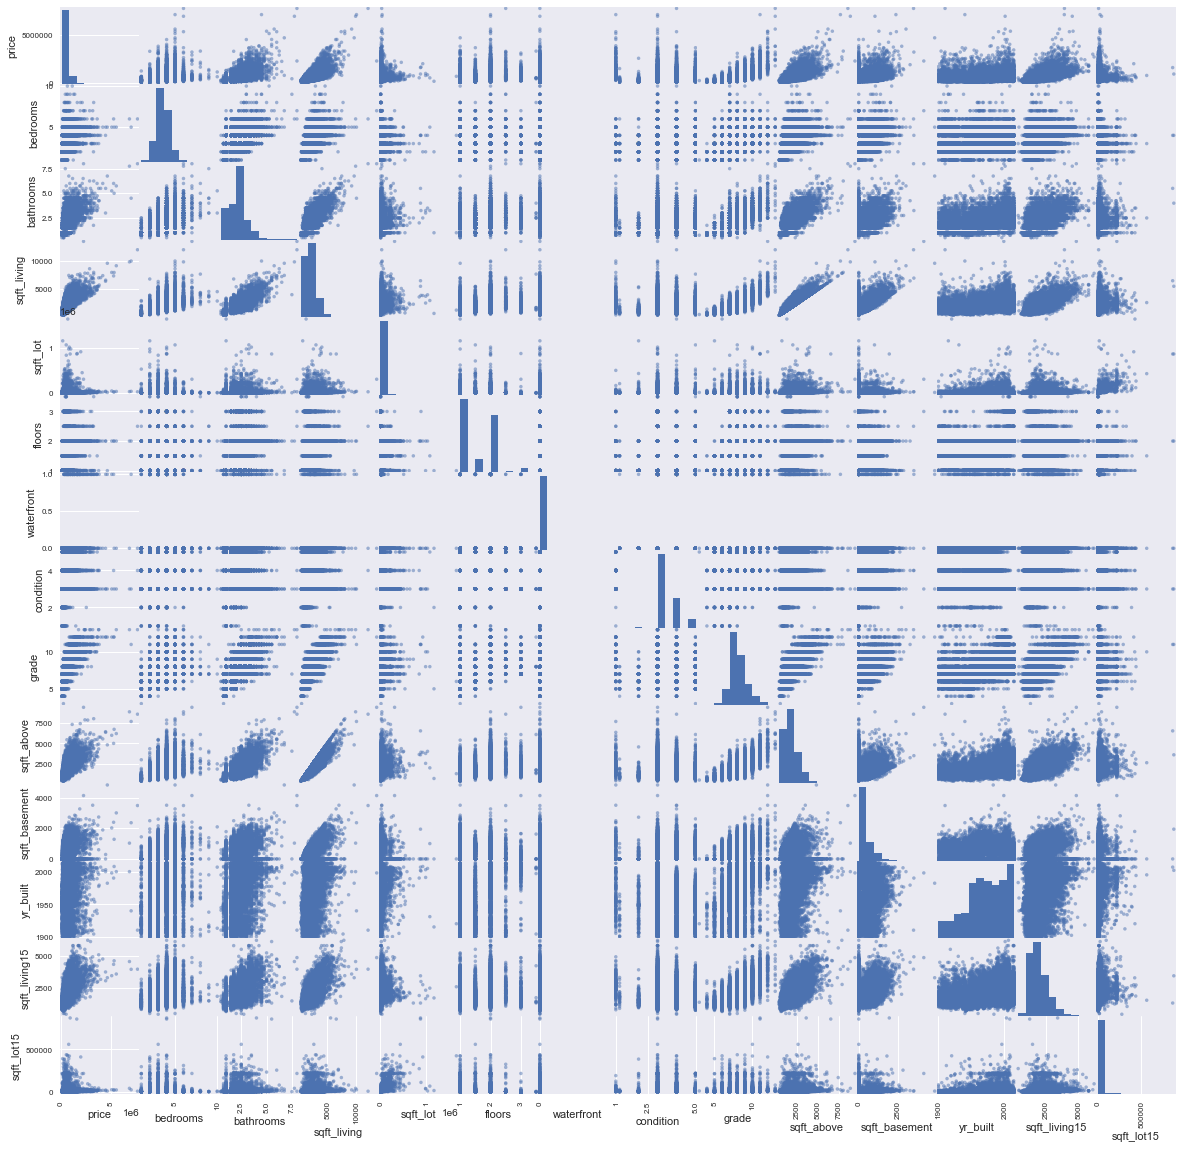

In [11]:
#using scatter plot to look for linear relationships
pd.plotting.scatter_matrix(cleaned_df, figsize = [20,20]);
plt.show()

### Analysis:
At first glance, the following variables seem to have linear relationships:
- price with bedrooms, sqft_above, & sqft_basement.
    - price also seems to have a linear relationship with categorical variable 'grade'.
- bedrooms with bathrooms, sqft_living, sqft_above, & sqft_basement
- sqft_living and sqft_above have the closest linear relationship
    - They are very similar data points. I may need to eliminate one to prevent multicolinearity.
    
The Following Variables seem to be categorical:
- floors
- waterfront
- condition
- zip code (not shown because I have already made it an object)

Ordinal Variables:
- bedrooms
- bathrooms



### What To Do with the Ordinal Values

I am going to treat grade as a continuous variable as it has very linear relationships with many features. Including price.

## Checking for Null Values

In [12]:
cleaned_df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
sqft_living15       0
sqft_lot15          0
dtype: int64

## Fixing Waterfront

In [ ]:
#cleaned_df['waterfront'].value_counts()

In [13]:
waterfront_cleaned = cleaned_df['waterfront'].fillna(0) 
cleaned_df['waterfront'] = waterfront_cleaned
cleaned_df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Building Condition

Should I change the condition values from numbers to words?

## Bedrooms

Should I change bedrooms so that there are less options? ie, <1 instead of 0, 0.5, etc

# Exploratory Data Analysis

In [14]:
cleaned_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15
count,2.159400e+04,21594.000000,21594.000000,21594.000000,2.159400e+04,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000
mean,5.402878e+05,3.371168,2.115808,2080.229740,1.510045e+04,1.494072,0.006761,3.409743,7.658007,1788.546633,291.683106,1971.003844,1986.674493,12759.056914
std,3.673922e+05,0.901536,0.769010,918.084207,4.141540e+04,0.539688,0.081950,0.650482,1.173256,827.749396,442.684260,29.374473,685.252555,27276.229189
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.619000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068475e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,2360.000000,10082.250000
max,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,6210.000000,871200.000000


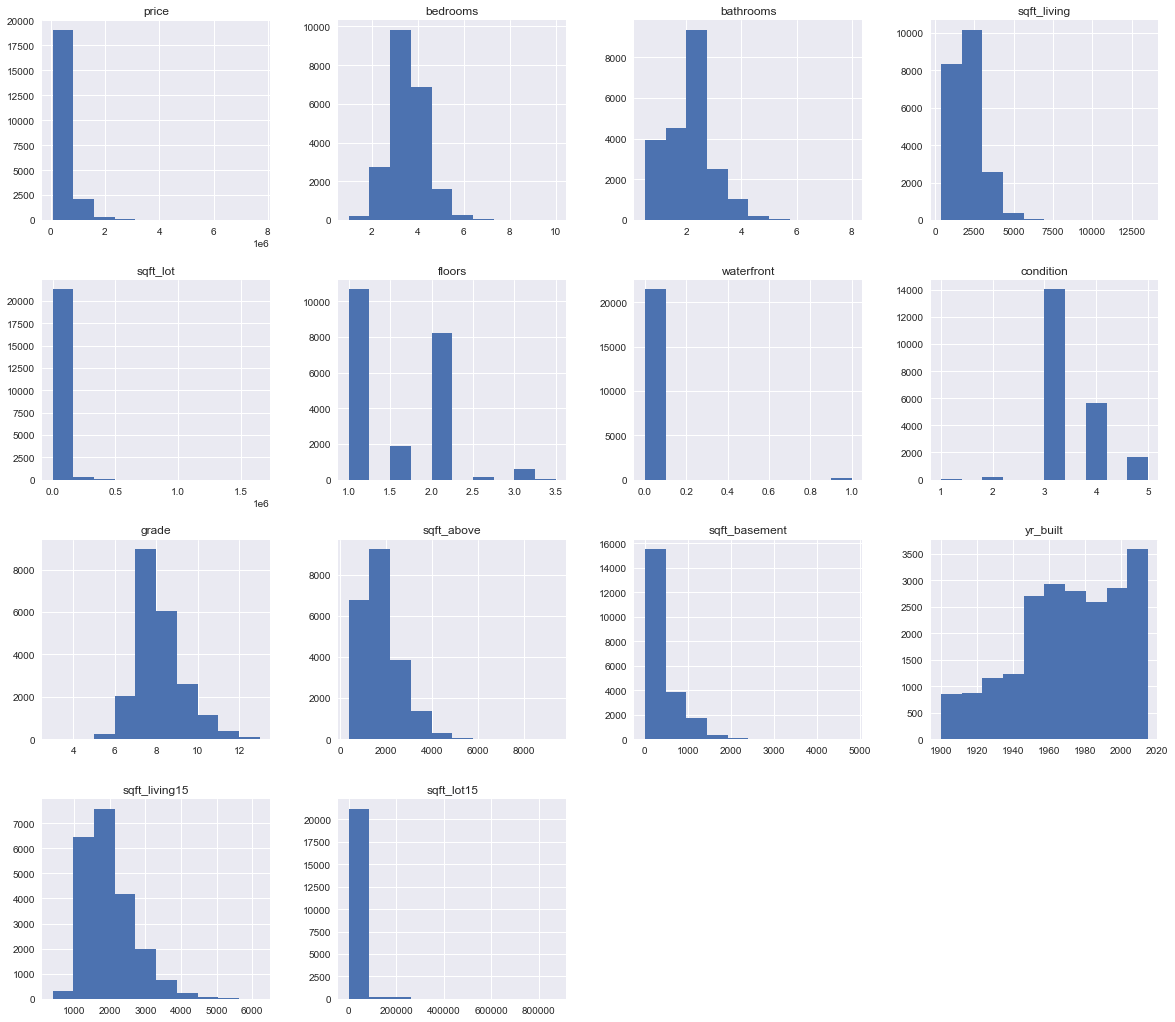

In [15]:
cleaned_df.hist(figsize = (20,18));

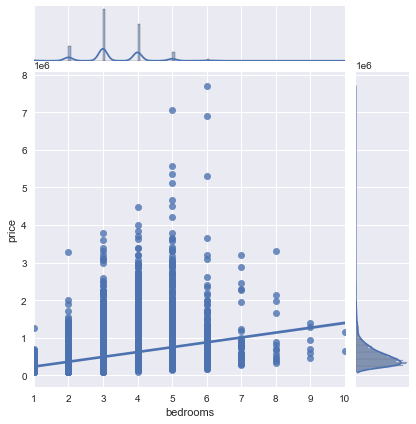

In [16]:
sns.jointplot('bedrooms','price', data=cleaned_df, kind='reg');

In [ ]:
# Slight Linearity?

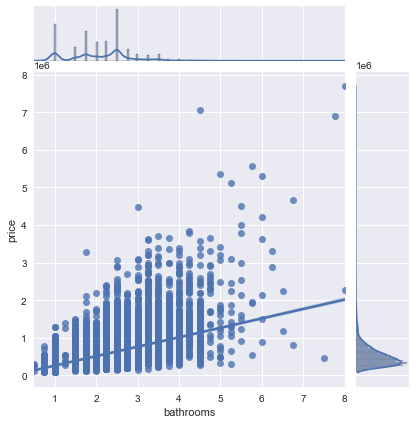

In [17]:
sns.jointplot('bathrooms','price', data=cleaned_df, kind='reg');

In [ ]:
# Fairly Linear. Especially if I remove the outliers.

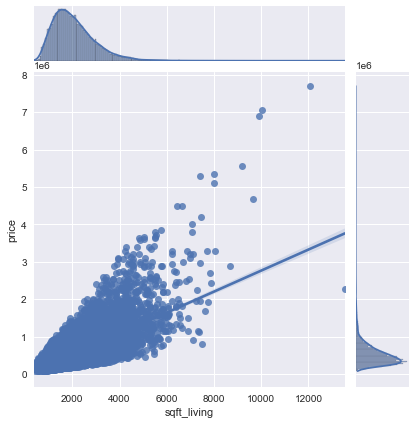

In [18]:
sns.jointplot('sqft_living','price', data=cleaned_df, kind='reg');

In [ ]:
# VERY linear relationship. Normal-ish distribution.

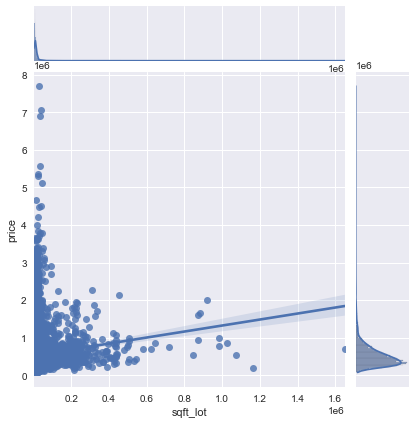

In [19]:
sns.jointplot('sqft_lot','price', data=cleaned_df, kind='reg');

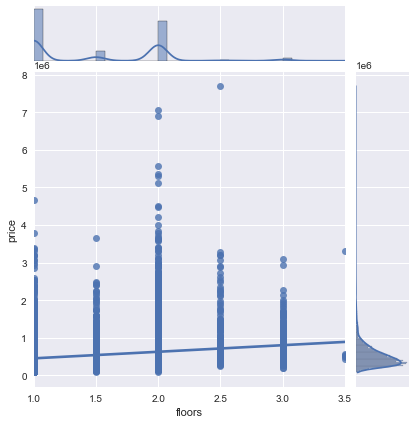

In [20]:
sns.jointplot('floors','price', data=cleaned_df, kind='reg');

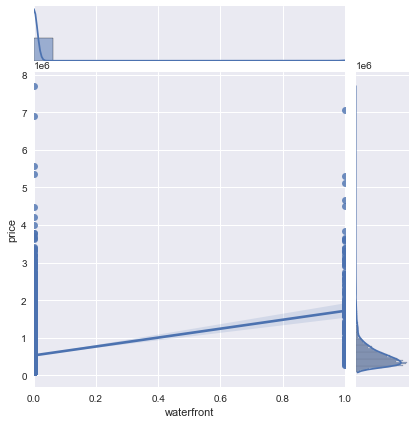

In [21]:
sns.jointplot('waterfront','price', data=cleaned_df, kind='reg');

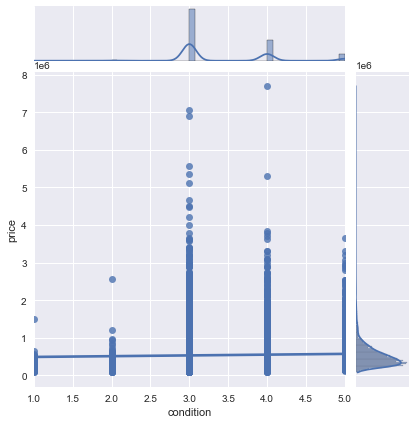

In [22]:
sns.jointplot('condition','price', data=cleaned_df, kind='reg');

In [ ]:
#interestingly, condition doesn't appear to have an affect on price.

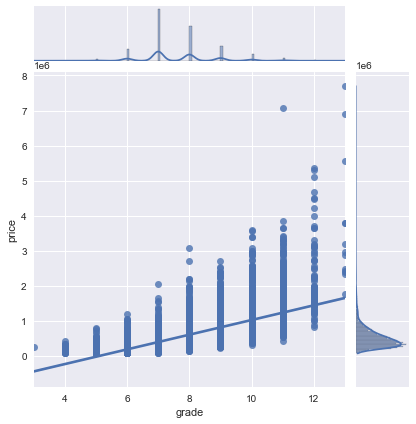

In [23]:
sns.jointplot('grade','price', data=cleaned_df, kind='reg');

In [ ]:
#linear relationship with a little noise

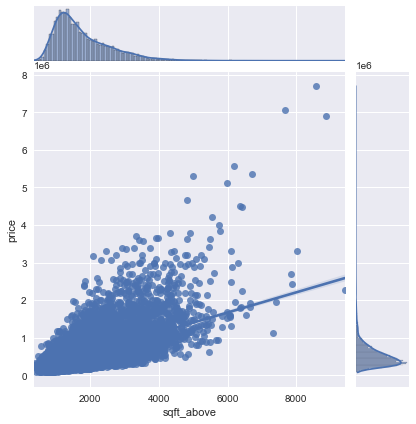

In [24]:
sns.jointplot('sqft_above','price', data=cleaned_df, kind='reg');

In [ ]:
#as expected. Very linear.

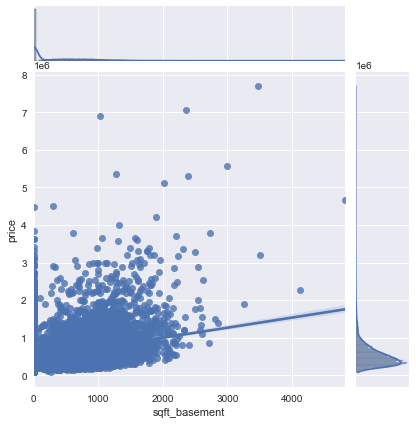

In [25]:
sns.jointplot('sqft_basement','price', data=cleaned_df, kind='reg');

In [ ]:
#slight linear relationship

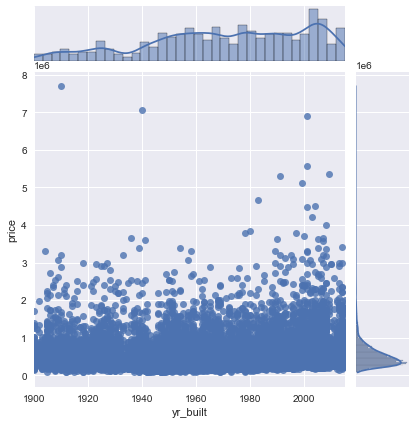

In [26]:
sns.jointplot('yr_built','price', data=cleaned_df, kind='reg');

In [ ]:
#no linearity

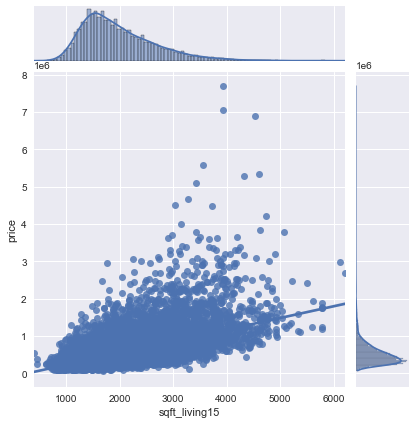

In [27]:
sns.jointplot('sqft_living15','price', data=cleaned_df, kind='reg');

In [ ]:
# fairly linear

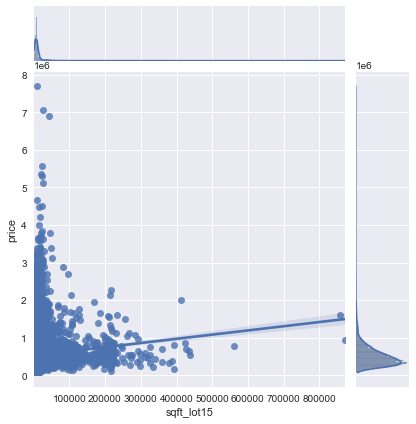

In [28]:
sns.jointplot('sqft_lot15','price', data=cleaned_df, kind='reg');

### Analysis of Jointplots
- As the data currently stands, sqft_living, sqft_above, and sqft_living15 are my best predictors.
- bedrooms, bathrooms, grade, sqft_lot, sqft_basement, and sqft_lot15 also show linear relationships and could possibly be improved
- condition and yr_built don't have linear relationships and therefore not much prediction power.

In [30]:
#lets go ahead and remove the features that aren't useful
cleaned_df = cleaned_df.drop(['condition', 'yr_built'], axis=1)
cleaned_df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15
3,660000.0,10,3.0,2920,3745,2.0,0.0,7,1860.0,1060.0,98105,1810,3745


In [31]:
feats = ['sqft_living', 'sqft_above', 'sqft_living15','bedrooms','bathrooms', 'grade', 'sqft_lot',
         'sqft_basement','sqft_lot15']
corr = cleaned_df[feats].corr()
corr

,sqft_living,sqft_above,sqft_living15,bedrooms,bathrooms,grade,sqft_lot,sqft_basement,sqft_lot15
sqft_living,1.000000,0.876432,0.756510,0.593994,0.755803,0.762923,0.173482,0.435114,0.184369
sqft_above,0.876432,1.000000,0.731837,0.493213,0.686700,0.756185,0.184159,-0.052206,0.195094
sqft_living15,0.756510,0.731837,1.000000,0.406011,0.569949,0.713865,0.144749,0.200510,0.183499
bedrooms,0.593994,0.493213,0.406011,1.000000,0.529021,0.367654,0.033822,0.309656,0.032107
bathrooms,0.755803,0.686700,0.569949,0.529021,1.000000,0.665890,0.088384,0.283441,0.088315
grade,0.762923,0.756185,0.713865,0.367654,0.665890,1.000000,0.114720,0.168282,0.120968
sqft_lot,0.173482,0.184159,0.144749,0.033822,0.088384,0.114720,1.000000,0.015435,0.718202
sqft_basement,0.435114,-0.052206,0.200510,0.309656,0.283441,0.168282,0.015435,1.000000,0.017570
sqft_lot15,0.184369,0.195094,0.183499,0.032107,0.088315,0.120968,0.718202,0.017570,1.000000


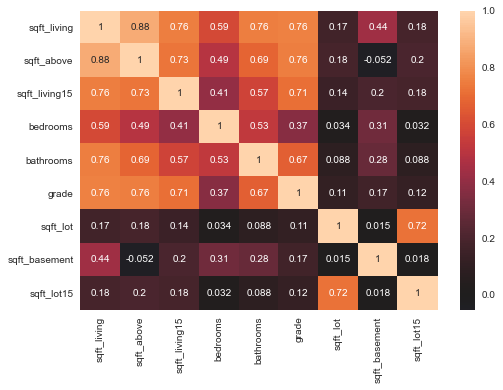

In [32]:
sns.heatmap(corr, center=0, annot=True);

# Initial Modeling 

## Version 2 - following the template in the practice Lab

In [33]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 3 to 21596
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21594 non-null  float64
 1   bedrooms       21594 non-null  int64  
 2   bathrooms      21594 non-null  float64
 3   sqft_living    21594 non-null  int64  
 4   sqft_lot       21594 non-null  int64  
 5   floors         21594 non-null  float64
 6   waterfront     21594 non-null  float64
 7   grade          21594 non-null  int64  
 8   sqft_above     21594 non-null  float64
 9   sqft_basement  21594 non-null  float64
 10  zipcode        21594 non-null  object 
 11  sqft_living15  21594 non-null  int64  
 12  sqft_lot15     21594 non-null  int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 2.9+ MB


In [34]:
list(cleaned_df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'grade',
 'sqft_above',
 'sqft_basement',
 'zipcode',
 'sqft_living15',
 'sqft_lot15']

In [35]:
# Defining the problem
outcome = 'price'
x_cols = list(cleaned_df.columns)
x_cols.remove(outcome)

In [36]:
train, test = train_test_split(cleaned_df)

#print(len(train), len(test))

In [37]:
print(len(train), len(test))
train.head()

16195 5399


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15
78,502000.0,6,2.50,2890,8122,1.0,0.0,8,1630.0,1260.0,98008,2730,9915
20833,790000.0,2,3.00,2560,982278,1.0,0.0,8,2560.0,0.0,98014,1620,40946
18834,562100.0,2,0.75,1440,3700,1.0,0.0,7,1200.0,240.0,98107,1440,4300
7421,390000.0,4,1.75,2330,8364,1.0,0.0,8,2330.0,0.0,98058,2180,9630
220,545000.0,6,1.75,1820,6250,1.0,0.0,7,1130.0,690.0,98116,1820,5750


In [38]:
test.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15
14487,359950.0,3,2.25,1940,11612,1.0,0.0,8,1100.0,840.0,98178,2180,8954
1212,480000.0,5,3.00,2240,15435,1.0,0.0,7,1390.0,850.0,98155,2240,10750
7591,700000.0,4,2.25,2690,15000,2.0,0.0,9,1890.0,800.0,98074,2670,15030
11631,450000.0,3,1.00,1140,4500,1.0,0.0,6,840.0,300.0,98144,1150,3000
16546,310000.0,3,1.75,1880,30346,1.0,0.0,8,1880.0,0.0,98001,2260,5883


In [39]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     769.0
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:18:17   Log-Likelihood:            -2.1794e+05
No. Observations:               16195   AIC:                         4.360e+05
Df Residuals:                   16115   BIC:                         4.367e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.777e+05   1.63e+04    -23.123      0.000    -4.1e+05   -3.46e+05
zipcode[T.98002]  5.057e+04   1.78e+04      2.843      0.004    1.57e+04    8.54e+04
zipcode[T.98003] -1.046e+04   1.56e+04     -0.670      0.503   -4.11e+04    2.02e+04
zipcode[T.98004]  7.837e+05   1.52e+04     51.561      0.000    7.54e+05    8.14e+05
zipcode[T.98005]  2.957e+05   1.83e+04     16.200      0.000     2.6e+05    3.32e+05
zipcode[T.98006]  2.967e+05   1.37e+04     21.672      0.000     2.7e+05    3.24e+05
zipcode[T.98007]  2.506e+05   2.01e+04     12.475      0.000    2.11e+05     2.9e+05
zipcode[T.98008]  2.877e+05   1.56e+04     18.404      0.000    2.57e+05    3.18e+05
zipcode[T.98010]  6.721e+04    2.3e+04      2.923      0.003    2.21e+04    1.12e+05
zipcode[T.98011]   1.12e+05   1.77e+04      6.337      0.000    7.73e+04    1.47e+05
zipcode[T.98014]  9.314e+04   2.05e+04      4.541      0.000    5.29e+04    1.33e+05
zipcode[T.98019]  8.523e+04   1.76e+04      4.854      0.000    5.08e+04     1.2e+05
zipcode[T.98022]  2.631e+04   1.65e+04      1.592      0.111   -6081.818    5.87e+04
zipcode[T.98023] -2.631e+04   1.35e+04     -1.944      0.052   -5.28e+04     213.079
zipcode[T.98024]  1.523e+05   2.43e+04      6.268      0.000    1.05e+05       2e+05
zipcode[T.98027]  1.666e+05   1.42e+04     11.708      0.000    1.39e+05    1.94e+05
zipcode[T.98028]  1.175e+05   1.52e+04      7.715      0.000    8.76e+04    1.47e+05
zipcode[T.98029]  2.094e+05   1.51e+04     13.888      0.000     1.8e+05    2.39e+05
zipcode[T.98030]  6163.6731   1.58e+04      0.391      0.696   -2.48e+04    3.71e+04
zipcode[T.98031]  1.855e+04   1.59e+04      1.167      0.243   -1.26e+04    4.97e+04
zipcode[T.98032]  1.488e+04   2.08e+04      0.715      0.475   -2.59e+04    5.57e+04
zipcode[T.98033]  3.744e+05   1.39e+04     26.993      0.000    3.47e+05    4.02e+05
zipcode[T.98034]  2.081e+05   1.33e+04     15.701      0.000    1.82e+05    2.34e+05
zipcode[T.98038]  1.949e+04   1.32e+04      1.477      0.140   -6379.949    4.54e+04
zipcode[T.98039]  1.315e+06   3.03e+04     43.422      0.000    1.26e+06    1.37e+06
zipcode[T.98040]  5.447e+05   1.58e+04     34.512      0.000    5.14e+05    5.76e+05
zipcode[T.98042]  7312.5764   1.32e+04      0.553      0.580   -1.86e+04    3.32e+04
zipcode[T.98045]  9.273e+04   1.69e+04      5.492      0.000    5.96e+04    1.26e+05
zipcode[T.98052]  2.181e+05   1.31e+04     16.590      0.000    1.92e+05    2.44e+05
zipcode[T.98053]  1.657e+05   1.44e+04     11.528      0.000    1.38e+05    1.94e+05
zipcode[T.98055]  6.034e+04   1.61e+04      3.746      0.000    2.88e+04    9.19e+04
zipcode[T.98056]  1.136e+05   1.41e+04      8.043      0.000    8.59e+04    1.41e+05
zipcode[T.98058]  2.435e+04   1.39e+04      1.748      0.081   -2961.734    5.17e+04
zipcode[T.98059]  7.179

In [40]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))
print(x_cols[:5])
p_table.head()

81 70
['zipcode[T.98002]', 'zipcode[T.98004]', 'zipcode[T.98005]', 'zipcode[T.98006]', 'zipcode[T.98007]']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,-3.777e+05,1.63e+04,-23.123,0.000,-4.1e+05,-3.46e+05
zipcode[T.98002],5.057e+04,1.78e+04,2.843,0.004,1.57e+04,8.54e+04
zipcode[T.98003],-1.046e+04,1.56e+04,-0.670,0.503,-4.11e+04,2.02e+04
zipcode[T.98004],7.837e+05,1.52e+04,51.561,0.000,7.54e+05,8.14e+05
zipcode[T.98005],2.957e+05,1.83e+04,16.200,0.000,2.6e+05,3.32e+05


### Refining Model

In [41]:
#removing problem zipcodes
df_1 = cleaned_df[cleaned_df['zipcode'] == '98002']
df_2 = cleaned_df[cleaned_df['zipcode'] == '98003']
df_3 = cleaned_df[cleaned_df['zipcode'] == '98004']
df_4 = cleaned_df[cleaned_df['zipcode'] == '98005']


print('df_1:', len(df_1))
print('df_2:', len(df_2))
print('df_3:', len(df_3))
print('df_4:', len(df_4))

df_1: 199
df_2: 280
df_3: 317
df_4: 168


Removing the problem zipcodes removes 4% of the data from the data set.
- 964 records removed from 21,596

In [42]:
problem_zips = pd.concat([df_1, df_2, df_3, df_4])
problem_zips

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15
120,370000.0,6,2.75,3240,5750,1.0,0.0,6,2160.0,1080.0,98002,1230,5750
190,343000.0,6,5.00,2732,7655,2.0,0.0,7,2732.0,0.0,98002,3078,69993
253,389000.0,6,4.50,3560,14010,2.0,0.0,7,3560.0,0.0,98002,1710,11116
259,300000.0,6,3.00,2400,9373,2.0,0.0,7,2400.0,0.0,98002,2060,7316
270,300000.0,6,5.25,2860,5682,2.0,0.0,7,2860.0,0.0,98002,1390,5956
311,300000.0,6,3.00,2744,9926,2.0,0.0,7,2744.0,0.0,98002,2470,9926
321,280000.0,6,3.00,2400,9373,2.0,0.0,7,2400.0,0.0,98002,2060,7316
327,260000.0,6,2.00,2220,8797,1.0,0.0,7,2220.0,0.0,98002,1170,5123
360,250750.0,5,1.75,2140,12058,1.0,0.0,8,2140.0,0.0,98002,1640,10125
602,319450.0,5,2.00,2250,5472,1.5,0.0,7,1750.0,500.0,98002,1540,5472


In [43]:
cleaned_df['zipcode'].value_counts().head()

98103    601
98038    589
98115    583
98052    574
98117    553
Name: zipcode, dtype: int64

In [44]:
new_df = cleaned_df.drop(problem_zips.index)
new_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15
3,660000.0,10,3.0,2920,3745,2.0,0.0,7,1860.0,1060.0,98105,1810,3745
5,450000.0,9,7.5,4050,6504,2.0,0.0,7,4050.0,0.0,98144,1448,3866
6,934000.0,9,3.0,2820,4480,2.0,0.0,7,1880.0,940.0,98105,2460,4400
7,700000.0,9,3.0,3680,4400,2.0,0.0,7,2830.0,850.0,98102,1960,2450
8,1400000.0,9,4.0,4620,5508,2.5,0.0,11,3870.0,750.0,98105,2710,4320
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,227000.0,1,2.0,1150,9812,1.0,0.0,7,1150.0,0.0,98001,1200,9812
21593,199900.0,1,1.0,720,7140,1.0,0.0,6,720.0,0.0,98146,1140,7577
21594,330600.0,1,1.0,580,1799,1.0,0.0,7,580.0,0.0,98117,1260,4000
21595,385195.0,1,1.0,710,6000,1.5,0.0,6,710.0,0.0,98144,1440,4800


In [45]:
#the problem zip codes have been removed so I can run my model again.
cleaned_df_2 = new_df

In [46]:
# Defining the problem
outcome = 'price'
x_cols = list(cleaned_df_2.columns)
x_cols.remove(outcome)

In [47]:
train, test = train_test_split(cleaned_df_2)

In [48]:
print(len(train), len(test))
train.head()

15472 5158


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15
12375,489000.0,3,1.50,1020,9072,1.0,0.0,7,920.0,100.0,98115,1620,7930
4180,906000.0,4,2.50,2480,5000,1.0,0.0,8,1480.0,1000.0,98105,2240,6071
14110,485000.0,3,2.25,2440,47916,2.0,0.0,8,2090.0,350.0,98053,2150,24000
5485,560000.0,4,2.50,2520,11240,1.0,0.0,8,1440.0,1080.0,98052,2360,10345
9806,360000.0,3,1.75,1020,7020,1.5,0.0,7,1020.0,0.0,98155,1020,5871


In [49]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     789.5
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:20:41   Log-Likelihood:            -2.0693e+05
No. Observations:               15472   AIC:                         4.140e+05
Df Residuals:                   15396   BIC:                         4.146e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -4.154e+05   1.53e+04    -27.217      0.000   -4.45e+05   -3.86e+05
zipcode[T.98006]  2.768e+05   1.28e+04     21.691      0.000    2.52e+05    3.02e+05
zipcode[T.98007]  2.362e+05   1.82e+04     12.998      0.000    2.01e+05    2.72e+05
zipcode[T.98008]  2.622e+05   1.42e+04     18.455      0.000    2.34e+05     2.9e+05
zipcode[T.98010]  7.503e+04   2.02e+04      3.723      0.000    3.55e+04    1.15e+05
zipcode[T.98011]  1.108e+05   1.58e+04      7.009      0.000    7.98e+04    1.42e+05
zipcode[T.98014]  1.016e+05   1.86e+04      5.468      0.000    6.52e+04    1.38e+05
zipcode[T.98019]  7.674e+04   1.61e+04      4.753      0.000    4.51e+04    1.08e+05
zipcode[T.98022]  2.592e+04   1.52e+04      1.700      0.089   -3957.973    5.58e+04
zipcode[T.98023] -4.176e+04   1.24e+04     -3.364      0.001   -6.61e+04   -1.74e+04
zipcode[T.98024]  1.513e+05   2.36e+04      6.419      0.000    1.05e+05    1.98e+05
zipcode[T.98027]  1.565e+05   1.31e+04     11.974      0.000    1.31e+05    1.82e+05
zipcode[T.98028]  1.189e+05   1.44e+04      8.240      0.000    9.06e+04    1.47e+05
zipcode[T.98029]  2.006e+05   1.38e+04     14.495      0.000    1.73e+05    2.28e+05
zipcode[T.98030] -5333.0756   1.48e+04     -0.359      0.719   -3.44e+04    2.38e+04
zipcode[T.98031]  2448.4580   1.45e+04      0.169      0.866   -2.59e+04    3.08e+04
zipcode[T.98032]  2.197e+04   1.89e+04      1.164      0.244    -1.5e+04     5.9e+04
zipcode[T.98033]  3.761e+05    1.3e+04     28.940      0.000    3.51e+05    4.02e+05
zipcode[T.98034]  2.005e+05   1.23e+04     16.324      0.000    1.76e+05    2.25e+05
zipcode[T.98038]  1.365e+04   1.21e+04      1.130      0.258      -1e+04    3.73e+04
zipcode[T.98039]  1.398e+06   2.64e+04     52.934      0.000    1.35e+06    1.45e+06
zipcode[T.98040]  5.336e+05   1.47e+04     36.395      0.000    5.05e+05    5.62e+05
zipcode[T.98042] -4429.2057   1.24e+04     -0.358      0.720   -2.87e+04    1.98e+04
zipcode[T.98045]  8.916e+04   1.52e+04      5.857      0.000    5.93e+04    1.19e+05
zipcode[T.98052]   2.13e+05   1.22e+04     17.529      0.000    1.89e+05    2.37e+05
zipcode[T.98053]  1.686e+05   1.32e+04     12.796      0.000    1.43e+05    1.94e+05
zipcode[T.98055]  4.973e+04   1.47e+04      3.381      0.001    2.09e+04    7.86e+04
zipcode[T.98056]  1.095e+05    1.3e+04      8.391      0.000    8.39e+04    1.35e+05
zipcode[T.98058]  2.489e+04   1.27e+04      1.965      0.049      61.540    4.97e+04
zipcode[T.98059]  6.953e+04   1.27e+04      5.473      0.000    4.46e+04    9.44e+04
zipcode[T.98065]  7.689e+04   1.42e+04      5.428      0.000    4.91e+04    1.05e+05
zipcode[T.98070]  2.586e+04   1.98e+04      1.303      0.193    -1.3e+04    6.48e+04
zipcode[T.98072]  1.345e+05   1.44e+04      9.336      0.000    1.06e+05    1.63e+05
zipcode[T.98074]  1.581

### Cleaning & Encoding

In [51]:
#dropping sqft_lot15 because of it's p-value
encoded_df = cleaned_df_2.drop(cleaned_df_2[['sqft_lot15']], axis=1)
encoded_df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_above,sqft_basement,zipcode,sqft_living15
3,660000.0,10,3.0,2920,3745,2.0,0.0,7,1860.0,1060.0,98105,1810


In [52]:
subs = [(' ', '_'),('.',''),("'",""),('™', ''), ('®',''),
        ('+','plus'), ('½','half'), ('-','_')
       ]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

In [53]:
encoded_df.columns = [col_formatting(col) for col in encoded_df.columns]

In [54]:
list(encoded_df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'grade',
 'sqft_above',
 'sqft_basement',
 'zipcode',
 'sqft_living15']

In [55]:
#one-hot encoding
#feats = ['bedrooms','floors', 'waterfront','zipcode']
feats = ['floors', 'waterfront','zipcode'] #treating bedrooms as a continous variable helps the model
#feats = ['zipcode']
encoded_df[feats] = encoded_df[feats].astype(str)
encoded_df = pd.get_dummies(encoded_df, drop_first=True)

In [ ]:
#encoded_df.info()

In [56]:
encoded_df.columns = [col_formatting(col) for col in encoded_df.columns]

In [57]:
list(encoded_df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'floors_15',
 'floors_20',
 'floors_25',
 'floors_30',
 'floors_35',
 'waterfront_10',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98055',
 'zipcode_98056',
 'zipcode_98058',
 'zipcode_98059',
 'zipcode_98065',
 'zipcode_98070',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode_98075',
 'zipcode_98077',
 'zipcode_98092',
 'zipcode_98102',
 'zipcode_98103',
 'zipcode_98105',
 'zipcode_98106',
 'zipcode_98107',
 'zipcode_98108',
 'zipcode_98109',
 'zipcode_9

### Normalizing Data

In [58]:
def norm_feat(series):
    return (series - series.mean())/series.std()

In [ ]:
#cleaned_df_2.info()

In [59]:
df_norm = norm_feat(encoded_df)
df_norm.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,sqft_living15,floors_15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,0.370957,7.376789,1.161134,0.937494,-0.271343,-0.555952,0.097239,1.759819,-0.246962,-0.314785,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
5,-0.236883,6.265752,7.035782,2.182665,-0.206136,-0.555952,2.761899,-0.660074,-0.779851,-0.314785,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
6,1.164043,6.265752,1.161134,0.827302,-0.253972,-0.555952,0.121574,1.485869,0.709881,-0.314785,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
7,0.486736,6.265752,1.161134,1.774954,-0.255863,-0.555952,1.277477,1.280406,-0.026152,-0.314785,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
8,2.512868,6.265752,2.466612,2.810759,-0.229676,2.884919,2.542886,1.052115,1.077898,-0.314785,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492


### Checking Multicolinearity with VIF scores

In [60]:
x_cols = list(df_norm.columns)
x_cols.remove(outcome)

In [61]:
X = df_norm[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


[('bedrooms', 1.767995155353305),
 ('bathrooms', 3.127254257135732),
 ('sqft_living', inf),
 ('sqft_lot', 1.2186913238842705),
 ('grade', 3.451994717418607),
 ('sqft_above', inf),
 ('sqft_basement', inf),
 ('sqft_living15', 3.173677007957456),
 ('floors_15', 1.2762929702230283),
 ('floors_20', 2.4502137326704814),
 ('floors_25', 1.111616061239859),
 ('floors_30', 1.3765044740321324),
 ('floors_35', 1.0083626268124972),
 ('waterfront_10', 1.0622416912027839),
 ('zipcode_98006', 2.417090428153525),
 ('zipcode_98007', 1.387784555122681),
 ('zipcode_98008', 1.7757752946164533),
 ('zipcode_98010', 1.2777402318750353),
 ('zipcode_98011', 1.5319451395150299),
 ('zipcode_98014', 1.3652862065115932),
 ('zipcode_98019', 1.523245866855921),
 ('zipcode_98022', 1.655967543847793),
 ('zipcode_98023', 2.3325100515302557),
 ('zipcode_98024', 1.2383854104321252),
 ('zipcode_98027', 2.129488749851739),
 ('zipcode_98028', 1.7648588658038151),
 ('zipcode_98029', 1.8958031762658767),
 ('zipcode_98030', 1.6

### Using old method to find colinear pairs

In [73]:
cc_df = df_norm.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.70) & (cc_df.cc<1)]

,cc
pairs,
"(sqft_living15, sqft_above)",0.73717


Analysis: sqft_living is causing a lot of multicollinearity. Dropping it will resolve most of the issues. I will also drop grade as it is so highly correlated to sqft_above, which is going to be one of my most important predictors.
- I am also dropping sqft_living15.

In [75]:
df_norm = df_norm.drop(['sqft_living', 'grade', 'sqft_living_15'], axis=1)
#df_norm = df_norm.drop(['sqft_living15'], axis=1)
df_norm.head(1)

,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,0.370957,7.376789,1.161134,-0.271343,0.097239,1.759819,-0.314785,1.265219,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492


In [76]:
cc_df = df_norm.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.70) & (cc_df.cc<1)]

,cc
pairs,


That took care of the correlated pairs. Now let's check the vif scores again and see if it resolved the infinite correlations.

In [77]:
x_cols = list(df_norm.columns)
x_cols.remove(outcome)

In [78]:
X = df_norm[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('bedrooms', 1.724308799038663),
 ('bathrooms', 3.056643751413851),
 ('sqft_lot', 1.2184973229356937),
 ('sqft_above', 3.1122183566501227),
 ('sqft_basement', 1.8043481858439907),
 ('floors_15', 1.270236332729379),
 ('floors_20', 2.425769872904832),
 ('floors_25', 1.1081910900844425),
 ('floors_30', 1.3464886616689333),
 ('floors_35', 1.0079668187020585),
 ('waterfront_10', 1.0610960021215228),
 ('zipcode_98006', 2.36359596567367),
 ('zipcode_98007', 1.3833914423764082),
 ('zipcode_98008', 1.7719799499725872),
 ('zipcode_98010', 1.2773800273267122),
 ('zipcode_98011', 1.5280327710171713),
 ('zipcode_98014', 1.3647641846389995),
 ('zipcode_98019', 1.521230137051646),
 ('zipcode_98022', 1.6558428201265247),
 ('zipcode_98023', 2.3282296084347234),
 ('zipcode_98024', 1.2380202501351325),
 ('zipcode_98027', 2.118739278896308),
 ('zipcode_98028', 1.7620223592295654),
 ('zipcode_98029', 1.8859993631714689),
 ('zipcode_98030', 1.6889484447407392),
 ('zipcode_98031', 1.7343291346567908),
 ('zi

I am happy with these VIF scores. There is still a decent correlation between sqft_above and bathrooms, but it is within the limits that I have set, and they are two predictors that I want to keep if at all possible.

### Running the model again

In [ ]:
#vif_scores = list(zip(x_cols, vif))
#x_cols = [x for x,vif in vif_scores if vif < 5]
#print(len(vif_scores), len(x_cols))

In [ ]:
#vif_scores

In [ ]:
# Defining the problem
#outcome = 'price'
#x_cols = list(df_norm.columns)
#x_cols.remove(outcome)

In [79]:
train, test = train_test_split(df_norm)

In [80]:
print(len(train), len(test))
train.head()

15472 5158


,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
13583,-0.775256,-0.400469,-0.470712,-0.183022,-0.024435,-0.660074,-0.314785,-0.790339,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
6056,1.441912,0.710568,1.161134,-0.118737,1.143635,1.211919,-0.314785,1.265219,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
17924,-0.474230,-0.400469,0.508396,-0.258061,0.364922,-0.660074,-0.314785,1.265219,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
7455,-0.019798,0.710568,0.508396,-0.121857,-0.328620,1.371723,-0.314785,-0.790339,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
16757,0.428846,-0.400469,0.182026,-0.125544,0.632605,-0.660074,-0.314785,1.265219,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492


In [81]:
test.head()

,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3886,-0.545145,0.710568,-0.470712,-0.213227,-0.730144,0.664019,-0.314785,-0.790339,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,8.816841,-0.08146,-0.117297,-0.12492
11039,-0.135577,-0.400469,-0.797082,-0.174254,-0.584135,0.641189,-0.314785,-0.790339,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
12590,-0.034270,-0.400469,0.182026,-0.103304,-0.498963,0.435727,-0.314785,-0.790339,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
13219,0.087298,-0.400469,-0.470712,-0.110985,-0.219113,-0.660074,-0.314785,-0.790339,-0.088408,-0.17396,...,-0.118984,-0.052635,6.727066,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
17422,-0.439496,-0.400469,0.182026,-0.075251,0.912455,-0.660074,-0.314785,1.265219,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492


In [82]:
# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     695.9
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        10:43:10   Log-Likelihood:                -10646.
No. Observations:               15472   AIC:                         2.145e+04
Df Residuals:                   15395   BIC:                         2.203e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0017      0.004      0.444      0.657      -0.006       0.009
bedrooms         -0.0995      0.005    -19.516      0.000      -0.110      -0.090
bathrooms         0.0627      0.007      9.263      0.000       0.049       0.076
sqft_lot          0.0291      0.004      6.715      0.000       0.021       0.038
sqft_above        0.6494      0.007     95.166      0.000       0.636       0.663
sqft_basement     0.2386      0.005     45.373      0.000       0.228       0.249
floors_15        -0.0101      0.004     -2.317      0.021      -0.019      -0.002
floors_20        -0.0826      0.006    -13.686      0.000      -0.094      -0.071
floors_25         0.0187      0.004      4.458      0.000       0.011       0.027
floors_30        -0.0436      0.004     -9.709      0.000      -0.052      -0.035
floors_35         0.0013      0.003      0.381      0.703      -0.005       0.008
waterfront_10     0.2000      0.004     51.349      0.000       0.192       0.208
zipcode_98006     0.1528      0.006     25.630      0.000       0.141       0.164
zipcode_98007     0.0666      0.004     14.869      0.000       0.058       0.075
zipcode_98008     0.0990      0.005     19.349      0.000       0.089       0.109
zipcode_98010     0.0115      0.004      2.684      0.007       0.003       0.020
zipcode_98011     0.0369      0.005      7.823      0.000       0.028       0.046
zipcode_98014     0.0158      0.004      3.538      0.000       0.007       0.025
zipcode_98019     0.0205      0.005      4.331      0.000       0.011       0.030
zipcode_98022     0.0047      0.005      0.955      0.340      -0.005       0.014
zipcode_98023    -0.0097      0.006     -1.637      0.102      -0.021       0.002
zipcode_98024     0.0263      0.004      6.256      0.000       0.018       0.035
zipcode_98027     0.0734      0.006     13.040      0.000       0.062       0.084
zipcode_98028     0.0456      0.005      8.931      0.000       0.036       0.056
zipcode_98029     0.0831      0.005     15.496      0.000       0.073       0.094
zipcode_98030     0.0007      0.005      0.136      0.892      -0.009       0.010
zipcode_98031     0.0060      0.005      1.166      0.244      -0.004       0.016
zipcode_98032     0.0047      0.005      1.008      0.314      -0.004       0.014
zipcode_98033     0.1658      0.006     29.015      0.000       0.155       0.177
zipcode_98034     0.1049      0.006     17.211      0.000       0.093       0.117
zipcode_98038     0.0056      0.006      0.904      0.366      -0.007       0.018
zipcode_98039     0.1981      0.004     49.874      0.000       0.190       0.206
zipcode_98040     0.2024      0.005     39.527      0.000       0.192       0.212
zipcode_98042     0.0007      0.006      0.114      0.909      -0.011       0.013
zipcode_98045     0.0293      0.005      5.903   

Model Analysis: 
- R2 is 77.5%. I would ideally like to see it at 80% or above, but this is very close.
- Prob(F-statistic) is 0, which means that there is good model integrity.
- Kurtosis is still really high. I will need to refine it so that it is closer to normal (3)
- Model is skewed. Still need to fix that.

# Checking Assumptions

## Checking Normality

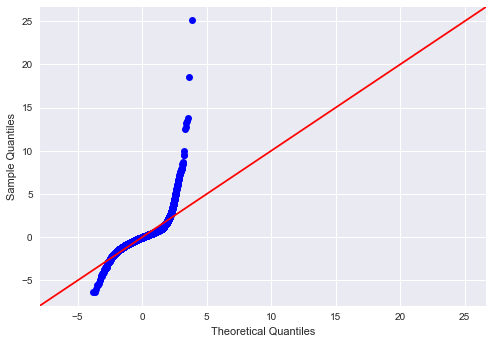

In [83]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

 there are more errors as price increases. This needs to be refined so that the model is accurate.

## Checking Homoscedasticity 

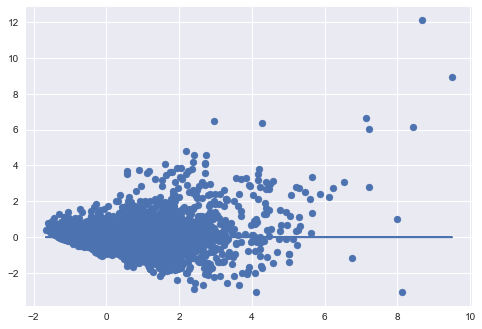

In [84]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

Funnel-shaped. Need to correct.

## Dealing with Outliers

I want to switch back to encoded_df so that I can see what the acutal price is, instead of the normalized price. O will drop the same columns that I dropped from df_norm so that they contain the same data.

In [91]:
#encoded_df = encoded_df.drop(['sqft_living', 'grade', 'sqft_living15'], axis=1)
encoded_df = encoded_df.drop(['sqft_living15'], axis=1)
encoded_df.head(1)

,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,660000.0,10,3.0,3745,1860.0,1060.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

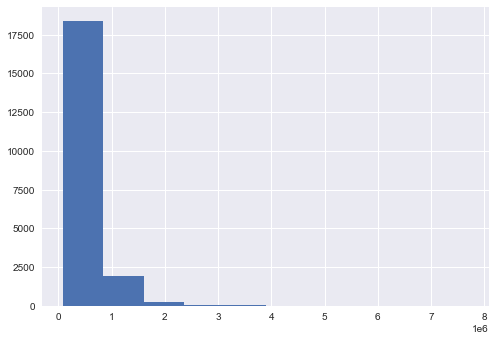

In [92]:
encoded_df.price.hist()

In [93]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, encoded_df.price.quantile(q=q)))

0.8 percentile: 690000.0
0.81 percentile: 701490.0000000016
0.82 percentile: 718000.0
0.83 percentile: 731127.9999999999
0.84 percentile: 750000.0
0.85 percentile: 761649.9999999979
0.86 percentile: 780000.0
0.87 percentile: 799268.9999999999
0.88 percentile: 818000.0
0.89 percentile: 840000.0
0.9 percentile: 862000.0
0.91 percentile: 890302.6399999995
0.92 percentile: 925000.0
0.93 percentile: 963990.0
0.94 percentile: 1010000.0
0.95 percentile: 1100000.0
0.96 percentile: 1200000.0
0.97 percentile: 1310000.0
0.98 percentile: 1500000.0
0.99 percentile: 1880000.0


In [105]:
#change to work with my variables
df = encoded_df

orig_tot = len(df)
df = df[df.price < 1500000] # Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df))/orig_tot)
df.price = df.price.map(np.log) # Applying a log transformation
train, test = train_test_split(df)

# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()


Percent removed: 0.020261754726127


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     842.4
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:00:57   Log-Likelihood:                 2631.6
No. Observations:               15159   AIC:                            -5109.
Df Residuals:                   15082   BIC:                            -4522.
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.8115      0.014    836.123      0.000      11.784      11.839
bedrooms         -0.0196      0.002     -8.001      0.000      -0.024      -0.015
bathrooms         0.0564      0.004     14.593      0.000       0.049       0.064
sqft_lot       7.245e-07   4.26e-08     17.003      0.000    6.41e-07    8.08e-07
sqft_above        0.0003   3.79e-06     90.146      0.000       0.000       0.000
sqft_basement     0.0002   5.27e-06     45.658      0.000       0.000       0.000
floors_15         0.0185      0.007      2.824      0.005       0.006       0.031
floors_20        -0.0289      0.005     -5.375      0.000      -0.039      -0.018
floors_25        -0.0479      0.022     -2.221      0.026      -0.090      -0.006
floors_30        -0.1143      0.012     -9.940      0.000      -0.137      -0.092
floors_35        -0.1530      0.092     -1.669      0.095      -0.333       0.027
waterfront_10     0.6820      0.029     23.317      0.000       0.625       0.739
zipcode_98006     0.7450      0.016     45.469      0.000       0.713       0.777
zipcode_98007     0.7125      0.023     30.644      0.000       0.667       0.758
zipcode_98008     0.7058      0.019     38.038      0.000       0.669       0.742
zipcode_98010     0.2278      0.026      8.649      0.000       0.176       0.279
zipcode_98011     0.4663      0.021     22.614      0.000       0.426       0.507
zipcode_98014     0.2626      0.024     10.849      0.000       0.215       0.310
zipcode_98019     0.2972      0.021     14.370      0.000       0.257       0.338
zipcode_98022     0.0888      0.020      4.540      0.000       0.050       0.127
zipcode_98023    -0.0032      0.016     -0.198      0.843      -0.034       0.028
zipcode_98024     0.4044      0.030     13.536      0.000       0.346       0.463
zipcode_98027     0.5526      0.017     33.012      0.000       0.520       0.585
zipcode_98028     0.4427      0.019     23.903      0.000       0.406       0.479
zipcode_98029     0.6435      0.018     35.474      0.000       0.608       0.679
zipcode_98030     0.0552      0.019      2.888      0.004       0.018       0.093
zipcode_98031     0.0895      0.018      4.868      0.000       0.053       0.126
zipcode_98032     0.0022      0.025      0.088      0.930      -0.048       0.052
zipcode_98033     0.8146      0.017     48.589      0.000       0.782       0.847
zipcode_98034     0.5486      0.016     34.862      0.000       0.518       0.579
zipcode_98038     0.1621      0.015     10.476      0.000       0.132       0.192
zipcode_98039     1.3427      0.058     23.219      0.000       1.229       1.456
zipcode_98040     0.9825      0.020     48.940      0.000       0.943       1.022
zipcode_98042     0.0685      0.016      4.363      0.000       0.038       0.099
zipcode_98045     0.3382      0.020     16.938   

Model Analysis: Removing some of the price outliers improved the model. (R2 is now at 80%)
- This only removed 2% of the data, which is acceptable.

## Checking Assumptions Again

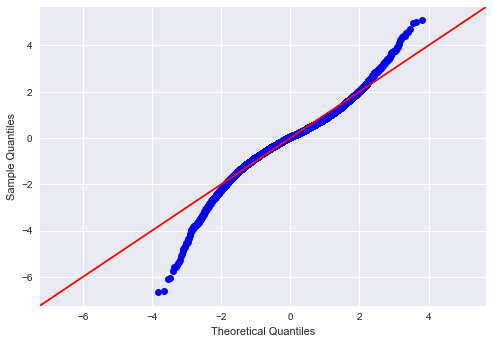

In [106]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

Normality is definitely improved, but isn't where it should be yet. 

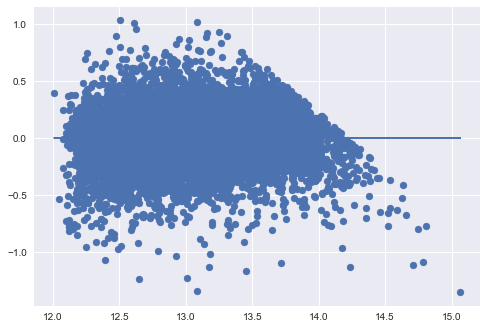

In [107]:
plt.scatter(model.predict(train[x_cols]), model.resid)
plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])

Homoscedasity: Also improved, but still not fully looking like it needs to.

If I attempt to remove more outliers from price, the model R2 score drops, and there is no difference with the assumption checks. I will need to refine other variables to improve my model.

In [ ]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.price.quantile(q=q)))

df.price.hist()

In [ ]:
#encoded_df.sort_values('price', ascending=True).head(200)
#encoded_df.price.value_counts().tail(1000)

# Alternative Approach: Building from the Ground Up

In [150]:
alt_df = encoded_df[['price', 'sqft_above', 'bedrooms', 'bathrooms', 'sqft_basement']]
alt_df

,price,sqft_above,bedrooms,bathrooms,sqft_basement
3,660000.0,1860.0,10,3.0,1060.0
5,450000.0,4050.0,9,7.5,0.0
6,934000.0,1880.0,9,3.0,940.0
7,700000.0,2830.0,9,3.0,850.0
8,1400000.0,3870.0,9,4.0,750.0
...,...,...,...,...,...
21592,227000.0,1150.0,1,2.0,0.0
21593,199900.0,720.0,1,1.0,0.0
21594,330600.0,580.0,1,1.0,0.0
21595,385195.0,710.0,1,1.0,0.0


In [151]:
x_cols = ['price', 'sqft_above', 'bedrooms', 'bathrooms', 'sqft_basement']

In [152]:
train, test = train_test_split(alt_df)

print(len(train), len(test))

15472 5158


In [153]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
alt_model = ols(formula=formula, data=train).fit()
alt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.754e+33
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:29:43   Log-Likelihood:             3.1993e+05
No. Observations:               15472   AIC:                        -6.398e+05
Df Residuals:                   15466   BIC:                        -6.398e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       3.22e-10   8.35e-12     38.546      0.000    3.06e-10    3.38e-10
price             1.0000   8.39e-18   1.19e+17      0.000       1.000       1.000
sqft_above     1.181e-13    4.5e-15     26.261      0.000    1.09e-13    1.27e-13
bedrooms      -9.095e-13   2.92e-12     -0.311      0.756   -6.64e-12    4.82e-12
bathrooms     -6.548e-11   4.09e-12    -16.028      0.000   -7.35e-11   -5.75e-11
sqft_basement   1.99e-13   6.05e-15     32.866      0.000    1.87e-13    2.11e-13
==============================================================================
Omnibus:                    10531.760   Durbin-Watson:                   0.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           382671.519
Skew:                           2.790   Prob(JB):                         0.00
Kurtosis:                      26.716   Cond. No.                     2.70e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.7e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [155]:
x_cols = list(alt_df.columns)
x_cols.remove(outcome)

In [156]:
X = alt_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('sqft_above', 13.33084627314011),
 ('bedrooms', 12.599039184071668),
 ('bathrooms', 18.999678465548744),
 ('sqft_basement', 1.880097447172962)]

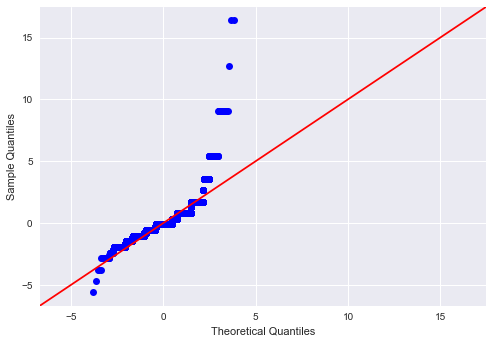

In [157]:
fig = sm.graphics.qqplot(alt_model.resid, dist=stats.norm, line='45', fit=True)

In [158]:
plt.scatter(alt_model.predict(train[x_cols]), alt_model.resid)
plt.plot(alt_model.predict(train[x_cols]), [0 for i in range(len(train))])

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'price' is not defined
    price~price+sqft_above+bedrooms+bathrooms+sqft_basement
    ^^^^^

Maybe I should drop bedrooms. They can be covered in my outcome as just "extra square feet added to the house". A bathroom is a more unique feature that I would like to capture.
- The normality assumption looks great now, but the model is still not homoscedastic.
- Let me check multicolinear pairs before dropping anything...

## normalizing and re-running

In [159]:
alt_df_norm = norm_feat(alt_df)
alt_df_norm.head()

,price,sqft_above,bedrooms,bathrooms,sqft_basement
3,0.370957,0.097239,7.376789,1.161134,1.759819
5,-0.236883,2.761899,6.265752,7.035782,-0.660074
6,1.164043,0.121574,6.265752,1.161134,1.485869
7,0.486736,1.277477,6.265752,1.161134,1.280406
8,2.512868,2.542886,6.265752,2.466612,1.052115


In [160]:
# Refit model with subset features
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
alt_model = ols(formula=formula, data=train).fit()
alt_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     3966.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):               0.00
Time:                        11:30:52   Log-Likelihood:            -2.1380e+05
No. Observations:               15472   AIC:                         4.276e+05
Df Residuals:                   15467   BIC:                         4.276e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.161e+05   7949.197     14.608      0.000    1.01e+05    1.32e+05
sqft_above      285.4322      3.648     78.233      0.000     278.281     292.584
bedrooms       -6.54e+04   2751.908    -23.764      0.000   -7.08e+04      -6e+04
bathrooms      1.614e+04   3912.770      4.125      0.000    8468.948    2.38e+04
sqft_basement   321.1909      5.194     61.840      0.000     311.010     331.372
==============================================================================
Omnibus:                    10851.457   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           460028.534
Skew:                           2.865   Prob(JB):                         0.00
Kurtosis:                      29.091   Cond. No.                     8.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [129]:
cc_df = alt_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.5) & (cc_df.cc<1)]

,cc
pairs,
"(sqft_above, bathrooms)",0.683479
"(price, sqft_above)",0.598397
"(price, bathrooms)",0.527955


It appears that bathrooms are the bigger problem.

In [134]:
#removing bathrooms to see what happens.
alt_df = alt_df.drop(['bathrooms'], axis=1)
alt_df.head()

,price,sqft_above,bedrooms,sqft_basement
3,660000.0,1860.0,10,1060.0
5,450000.0,4050.0,9,0.0
6,934000.0,1880.0,9,940.0
7,700000.0,2830.0,9,850.0
8,1400000.0,3870.0,9,750.0


In [135]:
x_cols = ['sqft_above', 'bedrooms', 'sqft_basement']

In [136]:
#checking VIF again to see what effect removing bedrooms had.
X = alt_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))1

[('sqft_above', 7.99602565564019),
 ('bedrooms', 9.5811163287823),
 ('sqft_basement', 1.6691774042658896)]

In [138]:
cc_df = alt_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.6) & (cc_df.cc<1)]

,cc
pairs,


In [132]:
#removing bedrooms to see what happens.
alt_df = alt_df.drop(['bedrooms'], axis=1)
alt_df.head()

,price,sqft_above,bathrooms,sqft_basement
3,660000.0,1860.0,3.0,1060.0
5,450000.0,4050.0,7.5,0.0
6,934000.0,1880.0,3.0,940.0
7,700000.0,2830.0,3.0,850.0
8,1400000.0,3870.0,4.0,750.0


In [126]:
x_cols = ['sqft_above', 'bathrooms', 'sqft_basement']

In [127]:
#checking VIF again to see what effect removing bedrooms had.
X = alt_df[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

[('sqft_above', 12.061758063564692),
 ('bathrooms', 14.448572381457803),
 ('sqft_basement', 1.7859634948114227)]

That didn't make much of a difference. 

# Taking what I learned back to the old model
- I am going to try dropping bathrooms and/or bedrooms from the old model to see if it fixes some of my issues.

In [161]:
df_norm.head()

,price,bedrooms,bathrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,0.370957,7.376789,1.161134,-0.271343,0.097239,1.759819,-0.314785,1.265219,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
5,-0.236883,6.265752,7.035782,-0.206136,2.761899,-0.660074,-0.314785,1.265219,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
6,1.164043,6.265752,1.161134,-0.253972,0.121574,1.485869,-0.314785,1.265219,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
7,0.486736,6.265752,1.161134,-0.255863,1.277477,1.280406,-0.314785,1.265219,-0.088408,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
8,2.512868,6.265752,2.466612,-0.229676,2.542886,1.052115,-0.314785,-0.790339,11.310672,-0.17396,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492


In [164]:
df_norm = df_norm.drop(['bathrooms'], axis=1)
df_norm.head(1)

,price,bedrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,floors_35,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,0.370957,7.376789,-0.271343,0.097239,1.759819,-0.314785,1.265219,-0.088408,-0.17396,-0.018423,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492


In [165]:
train, test = train_test_split(df_norm)

In [166]:
print(len(train), len(test))
train.head()

15472 5158


,price,bedrooms,sqft_lot,sqft_above,sqft_basement,floors_15,floors_20,floors_25,floors_30,floors_35,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
17907,0.001911,-0.400469,-0.280442,-0.973492,0.800994,-0.314785,-0.790339,-0.088408,-0.17396,-0.018423,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
14603,-0.951819,-0.400469,-0.206231,-1.143835,-0.660074,-0.314785,-0.790339,-0.088408,-0.17396,-0.018423,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
12181,0.168343,-0.400469,-0.239815,-0.121774,0.001972,-0.314785,1.265219,-0.088408,-0.17396,-0.018423,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
17411,-0.367135,-0.400469,-0.194485,0.218913,-0.660074,-0.314785,1.265219,-0.088408,-0.17396,-0.018423,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,-0.117297,-0.12492
17745,-0.948924,-0.400469,-0.064426,-0.705809,-0.660074,3.176619,-0.790339,-0.088408,-0.17396,-0.018423,...,-0.118984,-0.052635,-0.148646,-0.111647,-0.114939,-0.111869,-0.113414,-0.08146,8.524966,-0.12492


In [167]:
x_cols = list(df_norm.columns)
x_cols.remove(outcome)

In [169]:
X = df_norm[x_cols]
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(x_cols, vif))

ValueError: zero-size array to reduction operation maximum which has no identity

In [168]:
vif_scores = list(zip(x_cols, vif))
x_cols = [x for x,vif in vif_scores if vif < 5]
print(len(vif_scores), len(x_cols))

4 1


# Data Exploration

# Archive

## Baseline Model (Version 1)
- running a model with the cleaned data.

In [ ]:
# drop zipcode before running base model
base_df = cleaned_df
base_df = base_df.drop(base_df[['zipcode']], axis=1)
base_df.head()

In [ ]:
X = base_df.drop(['price'], axis=1)
y = base_df['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

### Baseline Normalization

In [ ]:
def norm_feat(series):
    return (series - series.mean())/series.std()

In [ ]:
df_base_norm = norm_feat(base_df)
df_base_norm.head()

In [ ]:
X = df_base_norm.drop('price', axis=1)
y = df_base_norm['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

### Checking for Multicolinearity

In [ ]:
#numeric variables
numeric_vars= ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

#numeric_vars= ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront',
#'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
numeric_vars

In [ ]:
cleaned_df.head(1)

In [ ]:
num_var_df = cleaned_df.loc[:,numeric_vars]
num_var_df.head()

In [ ]:
#scatter matrix for numeric variables
#pd.plotting.scatter_matrix(king_preprocessed, figsize=[20, 20]);

In [ ]:
#correlation matrix
num_var_df.corr()

In [ ]:
#abs(king_preprocessed.corr()) > 0.75

In [ ]:
cc_df = num_var_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.75) & (cc_df.cc<1)]

I need to remove some of these variables to prevent multicolineartiy. 


### Multicollinearity Analysis

There are 5 sets of variables that are highly correlated.  

In [ ]:
#removing these two variables removes all of the colinearity pairs
#king_preprocessed.drop(columns=['sqft_above', 'sqft_living'], inplace=True)

In [ ]:
num_var_df.head(1)

In [ ]:
col_test_df = num_var_df
col_test_df

In [ ]:
col_test_df = col_test_df.drop(columns=['grade', 'sqft_living'], axis=1)
col_test_df.head(1)

In [ ]:
cc_df = col_test_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.75) & (cc_df.cc<1)]

## Check VIF Scores!!!!

In [ ]:
#def variance_inflation_factors(exog_df):
#    exog_df = add_constant(exog_df)
#    vifs = pd.Series(
#        [1 / (1. - OLS(exog_df[col].values, 
#                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
#         for col in exog_df],
#        index=exog_df.columns,
#        name='VIF'
#    )
#    return vifs

## Model #2

## Make Changes to Model HERE!

In [ ]:
cleaned_df.head(1)

In [ ]:
# drop more columns?
changed_df = cleaned_df
changed_df = changed_df.drop(changed_df[['grade', 'sqft_above']], axis=1)
#changed_df.head()

In [ ]:
model_2 = changed_df
model_2.head(1)

In [ ]:
#one-hot encoding
#feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
#feats = ['bedrooms','waterfront', 'condition']
#changed_df[feats] = changed_df[feats].astype(str)
#changed_df = pd.get_dummies(changed_df, drop_first=True)

In [ ]:
#for Model 2 I am encoding waterfront and zipcode
#feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
feats = ['waterfront', 'zipcode']
model_2[feats] = model_2[feats].astype(str)
model_2 = pd.get_dummies(model_2, drop_first=True)
model_2.head()

## Run Model #2

In [ ]:
#df_norm.head()
test_df = model_2

In [ ]:
X = test_df.drop('price', axis=1)
y = test_df['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()X = test_df.drop('price', axis=1)
y = test_df['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

### Model #2 Normalized

In [ ]:
model_2_norm = norm_feat(model_2)
model_2_norm.head()

In [ ]:
X = model_2_norm.drop('price', axis=1)
y = model_2_norm['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

## Model #3
- model 3 has all of the features encoded.

In [ ]:
model_3 = changed_df
model_3.head()

In [ ]:
feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
model_3[feats] = model_3[feats].astype(str)
model_3 = pd.get_dummies(model_3, drop_first=True)
model_3.head()

In [ ]:
#df_norm.head()
X = model_3.drop('price', axis=1)
y = model_3['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

In [ ]:
#sns.pairplot(test_df)

In [ ]:
#sns.heatmap(king_preprocessed);

In [ ]:
king_preprocessed.head(1)

## One-Hot Encoding

In [ ]:
#feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
feats = ['bedrooms','waterfront', 'condition']
cleaned_df[feats] = cleaned_df[feats].astype(str)
cleaned_df = pd.get_dummies(cleaned_df, drop_first=True)

## Modeling

In [ ]:
#df['waterfront'].value_counts()

In [ ]:
#df['waterfront'] = df['waterfront'].astype('bool') #converting waterfront into boolean

## Resetting IDs to make them shorter

In [ ]:
X = test_df.drop('price', axis=1)
y = test_df['price']

## Should I drop low grade?

In [ ]:
low_grade = cleaned_df[cleaned_df['grade'] <= 5]
low_grade.head()

## Plotting Categoricals

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10), sharey=True)

for col, ax in zip(categoricals, axes.flatten()):
    (king_preprocessed.groupby(col)               # group values together by column of interest
         .mean()['price']        # take the mean of the saleprice for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()


In [ ]:
#sns.heatmap(df_norm);

## One-Hot Encoding using Skilearn

In [ ]:
#trying sklearn method
ohe = OneHotEncoder(drop='first')

In [ ]:
data_trans = ohe.fit_transform(king_preprocessed)
data_trans.todense()

In [ ]:
data_trans = pd.DataFrame(data_trans.todense(), columns=ohe.get_feature_names())
data_trans.head()